## EDA on Model Behaviors
---

In this refit we uncoverred a lot of...behavioral differences of the model. We will use this notebook to find out why and iterate on improving the model.


### Goal
We need to create a model that:
1. have good performance metrics
2. have similar scoring performance with respect to the incumbent model
    * by preserving users in the same bin
    * and/or similar score distribution for active and in-active users
3. reduced features used

### Currently experimenting: TODO
---
Some thoughts: with experience I have now, two directions stand out from the rest:
0. Observe score distribution at the point of model development
1. modify the train-validate time range. 
2. reweigh active, inactive, and indeterminates

Most of our headache comes from when the model being lenient on in-active accounts. It would be made worse, of course, if the model penalizes good users.

If I have superpower, the 4x4 active score distribution plot will shift in the way such that:
* top-left: new score shifts right 
* top-right: new score shifts right
* bottom-left: new score shifts left
* bottom-right: new score shifts right

**Consider treating inactive as some kind of bad? give it less weight maybe?**

**TODO**
- [ ] study model behavior if trained over different train data range
    - see if we can rediscover the originally train model
    - study the behavior with and without dropping indeterminate from a historical perspective
    - also the effect of dropping the active accounts from the static data
- [ ] continuing bullet 3 in the last todo, consider broader reweighing mechanism


#### Notebook 4.1
* Method 1: new ind def, drop during training
    * result similar to new ind def, refitted - not good enough
* Method 2: old ind def, drop during training
    * result similar to old ind def, refitted - not good enough
* **Promising** Method 3: kept ind during training
    * performance metric similar to the our score_20201130_w_ind_bad_rate option. The score distribution is better as the score_distribution is closer to the original model than the
* Method 4: kept ind during training, scaled by bad rate
    * no significant out-performance w.r.t. Method 3
* Method 5: kept ind during training, with 200 trees instead of 1400
    * Same as 5.1
* Method 5.1: kept ind during training, with 200 trees instead of 1400, scaled by bad rate
    * Slightly underperformed Method 3, and performance segmented by activeness does not behave well


* Method 6: dropped ind during training, with WOE monotonic constraints
* Method 7: dropped ind during training


### In addition, we can 
* [ ] reduce the range of date used for training. This may allow closer relation with respect to the original dataset used.
* [x] measure psi of indeterminates
    * [ ] change to multi-class classification, with indeterminates as its individual class
* [ ] rescale by indeterminates

#### PSI of Indeterminates
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import src.monitoring.utils as mu
import src.monitoring.monitoring as mntr
import rdsutils.score_alignment as sa
import rdsutils

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# prev data
# dev_path = "s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/tb-dev/modeling_df_final_2020-05-14.feather"
# df = pd.read_feather(dev_path)
# df = mu.preprocess(df)
# df.shape, "indeterminate" in df.columns

# we do not have indeterminate in the old df, need to segment the current df

In [3]:
# train valid data
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_scored.parquet"))

In [20]:
def build_indeterminate(df):
    return ((pd.to_datetime(df["dtc"]) <= df["sample_date"])
            | (df["last_unrestricted_date"] <= df["sample_date"])
            | (df["chg_wrt_off_date"] <= df["sample_date"])
            | (df["target"] & (df["latest_acc_bal"] > 0))
            | (
                ~df["target"] & (~df["chg_wrt_off_date"].isna())
                | (df["latest_acc_bal"] < 0)
                | (
                    df["closed_reason"].isin(
                        [
                            "Closed by SoFi - Risk Request",
                            "Closed by SoFi - Charge-Off / Write-Off",
                        ]
                    )
                )
                | (df["restricted_reason"].str.startswith("No"))
            ))

train_df["indeterminate_prev"] = build_indeterminate(train_df)  
test_df["indeterminate_prev"] = build_indeterminate(test_df)

### Test data indeterminate PSI

In [21]:
df_past = train_df[train_df.sample_date == pd.to_datetime("2020-01-01")]
df_now = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")]
df_past.shape, df_now.shape

((166781, 96), (653852, 107))

In [22]:
df_past.indeterminate_prev.value_counts(normalize=True)

False    0.97023
True     0.02977
Name: indeterminate_prev, dtype: float64

In [25]:
df_past.indeterminate.value_counts(normalize=True)

True     0.622865
False    0.377135
Name: indeterminate, dtype: float64

In [26]:
df_now.indeterminate.value_counts(normalize=True)

True     0.805106
False    0.194894
Name: indeterminate, dtype: float64

In [5]:
from rdsutils.post_implementation_testing import (
    get_psi
)

psi_df = get_psi(df_past.indeterminate.to_frame().astype(int), 
                 df_now.indeterminate.to_frame().astype(int),
                 buckets=2).round(5)
psi_df

,feature,psi
0,indeterminate,0.16708


In [6]:
df_past.indeterminate.value_counts(normalize=True)

True     0.622865
False    0.377135
Name: indeterminate, dtype: float64

In [7]:
df_now.indeterminate.value_counts(normalize=True)

True     0.805106
False    0.194894
Name: indeterminate, dtype: float64

### Justify how does dropping inactive bads make such a huge difference now

#### Compare the historical training data with and without that indeterminate feature

<AxesSubplot:>

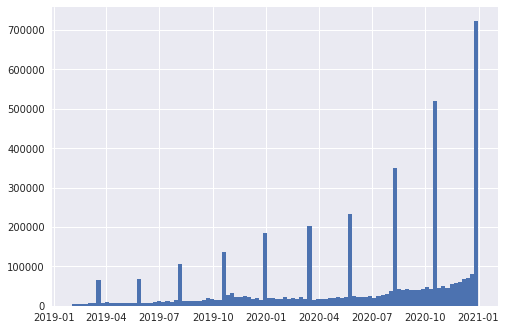

In [8]:
train_df.sample_date.hist(bins=100)

In [13]:
df_past = train_df[train_df.sample_date <= pd.to_datetime("2020-01-01")]
df_now = train_df

In [16]:
df_past.indeterminate_prev.value_counts(normalize=True)

False    0.930807
True     0.069193
Name: indeterminate_prev, dtype: float64

In [18]:
df_past[["indeterminate", "indeterminate_prev"]].value_counts(normalize=True)

indeterminate  indeterminate_prev
False          False                 0.674662
True           False                 0.256144
False          True                  0.047928
True           True                  0.021265
dtype: float64

In [14]:
df_past.indeterminate.value_counts(normalize=True)

False    0.72259
True     0.27741
Name: indeterminate, dtype: float64

In [15]:
df_now.indeterminate.value_counts(normalize=True)

False    0.62673
True     0.37327
Name: indeterminate, dtype: float64

#### Those are statistics on training data

In terms of training data, we are able to replicate it by dropped the inactive accounts. 